# Data preprocessing
This script fetches and processes data from a user's anime list on MyAnimeList

In [63]:
import requests
import pandas as pd
from config import CLIENT_ID, USER_NAME

# Constructing the URL for API request using USER_NAME
url = f'https://api.myanimelist.net/v2/users/{USER_NAME}/animelist'

# Setting headers for the API request, including the CLIENT_ID
headers = {
    'X-MAL-CLIENT-ID': CLIENT_ID
}

# Setting parameters for the API request to specify limit and fields
params = {
    'limit': 400,
    'fields': 'list_status{score},alternative_titles{en},mean,genres,popularity'
}

# Making a GET request to the API endpoint
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    # Parsing the JSON response into Python dictionary
    anime_data = response.json()
    
    modified_anime_data = []
    
    # Iterating through each anime entry in the API response
    for anime in anime_data['data']:
        anime_info = anime['node']  # Extracting anime information
        list_status = anime.get('list_status', {})  # Extracting list status information
        
        # Creating a modified anime entry with selected attributes
        modified_anime = {
            'user_score': list_status.get('score'),
            'title': anime_info.get('alternative_titles', {}).get('en'),
            'mal_score': anime_info.get('mean'),
            'genres': [genre['name'] for genre in anime_info.get('genres', [])],
            'popularity': anime_info.get('popularity')
        }
        
        modified_anime_data.append(modified_anime)
    
    # Creating a DataFrame from the modified anime data
    df = pd.DataFrame(modified_anime_data)
    print(df.head(2))
    

    csv_file_path = './data/anime_list.csv'
    df.to_csv(csv_file_path, index=False, encoding='utf-8')

    print(f"Data successfully written to '{csv_file_path}'")
else:
    print(f"Failed to retrieve data: {response.status_code}")

   user_score                            title  mal_score  \
0           4  I'm Standing on a Million Lives       6.51   
1           6                             22/7       6.79   

                                              genres  popularity  
0  [Action, Adventure, Drama, Fantasy, Isekai, Sh...         821  
1                     [Drama, Idols (Female), Music]        3335  
Data successfully written to './data/anime_list.csv'


In [64]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras import regularizers
import numpy as np


df = pd.read_csv('./data/anime_list.csv')
# Loading the pre-trained Word2Vec model
word_vectors = Word2Vec.load('./models/anime_word2vec_model_updated')

df.columns = df.columns.astype(str)
# Handling missing values in the title column by replacing them with empty strings
df['title'] = df['title'].fillna('')

# Function to convert anime titles into vectors using the Word2Vec model
def title_to_vector(anime_title):
    # Getting the vector size from the model
    vector_size = word_vectors.vector_size
    # Initializing the vector with zeros
    vector = np.zeros(vector_size)
    # Split the title into individual words
    words = str(anime_title).split()
    word_count = 0
    for word in words:
        # Checking if the word exists in the Word2Vec vocabulary
        if word in word_vectors.wv:
            vector += word_vectors.wv[word]
            word_count += 1
    # Returning the average vector or a zero vector if no words found
    return vector / word_count if word_count > 0 else vector

df['title_vector'] = df['title'].apply(title_to_vector)

# Converting the title_vector column into separate columns for each vector component
title_vectors = pd.DataFrame(df['title_vector'].tolist(), index=df.index)
df = pd.concat([df, title_vectors], axis=1).drop(['title_vector', 'title'], axis=1)

# One-hot encoding the genres column
genres_encoder = OneHotEncoder(sparse_output=False)
genres_encoded = genres_encoder.fit_transform(df[['genres']])
genres_encoded_df = pd.DataFrame(genres_encoded, columns=genres_encoder.get_feature_names_out(['genres']))
df = pd.concat([df, genres_encoded_df], axis=1).drop('genres', axis=1)

# Ensuring all column names are strings
df.columns = df.columns.astype(str)

# Normalizing numerical data using StandardScaler
numerical_columns = ['mal_score',  'popularity', 'user_score']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Defining the target variable Y and features X
Y = df['user_score']
X = df.drop(['user_score'], axis=1)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Algorithms

## Support Vector Regression


In [67]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train an SVM model with RBF kernel
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svm_model.predict(X_test)

# Evaluate the model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Mean absolute error: {mae_svr:.2f}")
print(f"Mean squared error: {mse_svr:.2f}")


Mean absolute error: 0.66
Mean squared error: 0.75


## Linear Regression

In [68]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean absolute error: {mae:.2f}")
print(f"Mean squared error: {mse:.2f}")

Mean absolute error: 3297375318983.64
Mean squared error: 121640814683734862351826944.00


## Decision Tree

In [69]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred_dt = regressor.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Mean absolute error: {mae_dt:.2f}")
print(f"Mean squared error: {mse_dt:.2f}")

Mean absolute error: 0.80
Mean squared error: 1.06


## Random Forest

In [70]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred_rf = regressor.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean absolute error: {mae_rf:.2f}")
print(f"Mean squared error: {mse_rf:.2f}")

Mean absolute error: 0.69
Mean squared error: 0.75


## K Nearest Neighbors

In [71]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
regressor.fit(X_train, y_train)

y_pred_knn = regressor.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"Mean absolute error: {mae_knn:.2f}")
print(f"Mean squared error: {mse_knn:.2f}")

Mean absolute error: 0.64
Mean squared error: 0.65


## Gradient Boosting

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred_gb = regressor.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Mean absolute error: {mae_gb:.2f}")
print(f"Mean squared error: {mse_gb:.2f}")

Mean absolute error: 0.66
Mean squared error: 0.66


## Neural Network training
This script performs data preprocessing and trains a neural network to predict user scores for anime titles

In [65]:
# Defining the neural network model architecture
# Number of input features
input_shape = X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(input_shape,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compiling the model with optimizer, loss function, and evaluation metrics
model.compile(optimizer='sgd',
              loss='mse',  # Mean Squared Error
              metrics=['mae'])  # Mean Absolute Error

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluating the model on the test data
loss, mae_nn = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {mae_nn}')

C:\Users\dobre\Documents\Code\Anime_Rating_Project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0786 - mae: 0.8232 - val_loss: 1.1838 - val_mae: 0.8741
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0166 - mae: 0.7952 - val_loss: 1.1528 - val_mae: 0.8598
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0464 - mae: 0.8022 - val_loss: 1.1255 - val_mae: 0.8486
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0025 - mae: 0.7508 - val_loss: 1.1030 - val_mae: 0.8419
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0201 - mae: 0.7695 - val_loss: 1.0849 - val_mae: 0.8375
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0300 - mae: 0.7831 - val_loss: 1.0688 - val_mae: 0.8328
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9955 - mae: 0.7640 - val_loss: 1.0576 - val_mae: 0.8298
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9162 - mae: 0.7327 - val_loss: 1.0481 - val_mae: 0.8269
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9381 - mae: 0.7312 -

# Visualizing

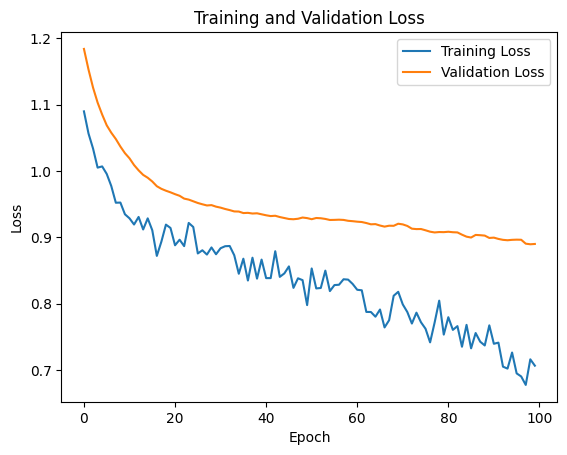

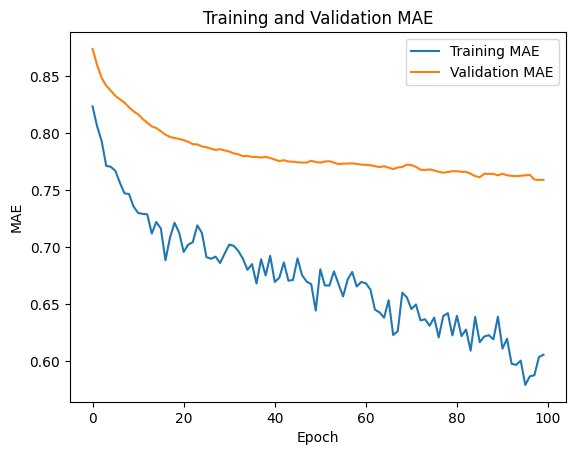

In [66]:
import matplotlib.pyplot as plt

# Getting the loss and metric values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation MAE over epochs
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

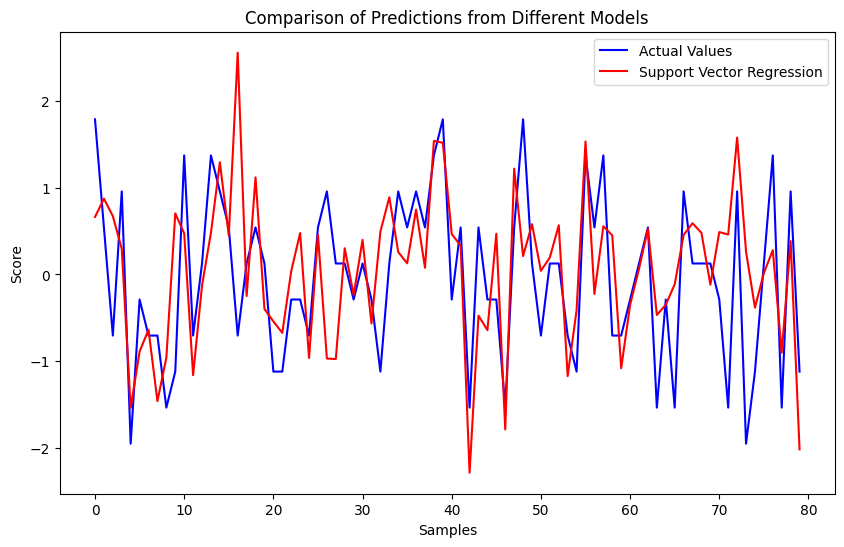

In [81]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(y_test)), y_pred_svr, label='Support Vector Regression', color='red')
# plt.plot(range(len(y_test)), y_pred_dt, label='Decision Tree', color='violet')
# plt.plot(range(len(y_test)), y_pred_rf, label='Random Forest', color='orange')
# plt.plot(range(len(y_test)), y_pred_knn, label='KNN', color='green')
# plt.plot(range(len(y_test)), y_pred_gb, label='Gradient Boosting Regressor', color='yellow')

plt.title('Comparison of Predictions from Different Models')
plt.xlabel('Samples')
plt.ylabel('Score')
plt.legend()
plt.show()


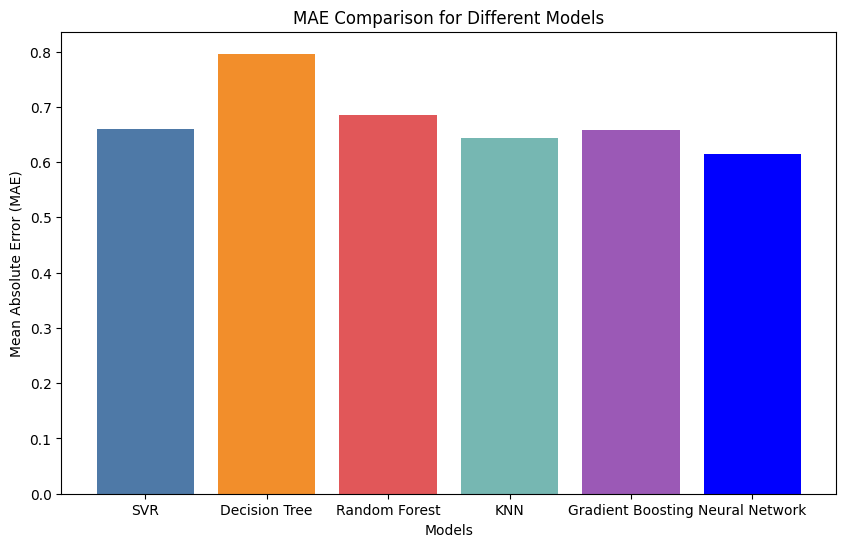

In [80]:
import numpy as np

# Example of metrics for each model
models = ['SVR', 'Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting', 'Neural Network']
mae_values = [mae_svr, mae_dt, mae_rf, mae_knn, mae_gb, mae_nn]  # Insert actual MAE values

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#9B59B6', 'blue'])

plt.title('MAE Comparison for Different Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Models')
plt.show()

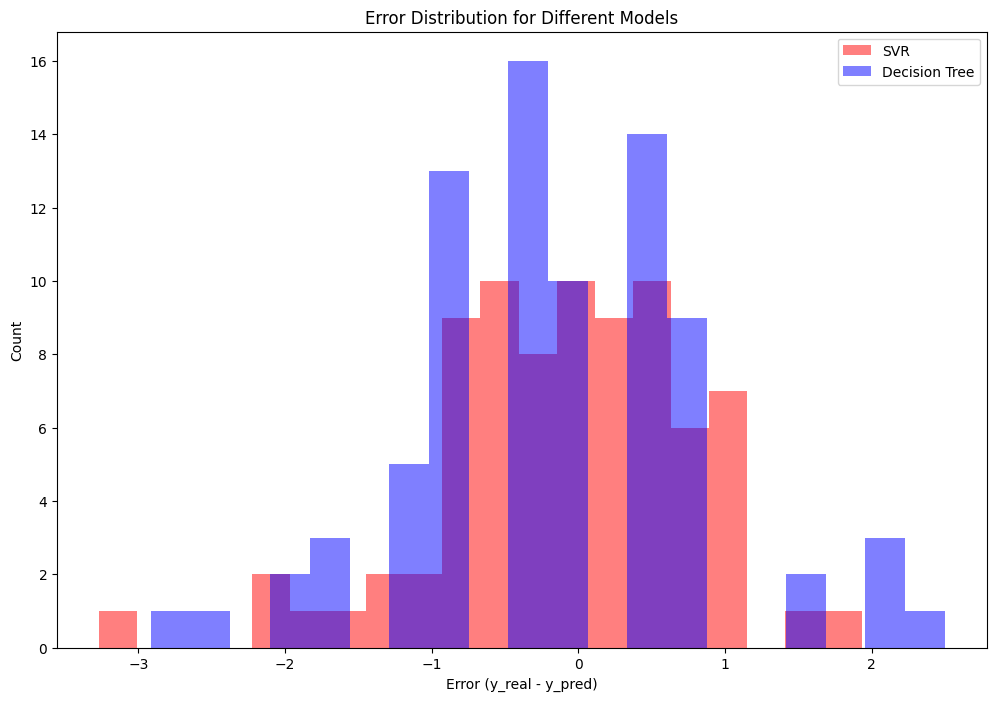

In [78]:
plt.figure(figsize=(12, 8))

# error_ for each model
errors_svr = y_test - y_pred_svr
errors_dt = y_test - y_pred_dt
errors_rf = y_test - y_pred_rf
errors_knn = y_test - y_pred_knn
errors_gb = y_test - y_pred_gb


plt.hist(errors_svr, bins=20, alpha=0.5, label='SVR', color='red')
plt.hist(errors_dt, bins=20, alpha=0.5, label='Decision Tree', color='blue')
# plt.hist(errors_rf, bins=20, alpha=0.5, label='Random Forest', color='orange')
# plt.hist(errors_knn, bins=20, alpha=0.5, label='KNN', color='green')
# plt.hist(errors_gb, bins=20, alpha=0.5, label='Gradient Boosting', color='brown')

plt.title('Error Distribution for Different Models')
plt.xlabel('Error (y_real - y_pred)')
plt.ylabel('Count')
plt.legend()
plt.show()


C:\Users\dobre\AppData\Local\Temp\ipykernel_16952\2258314224.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(predictions.values(), labels=predictions.keys(), patch_artist=True,


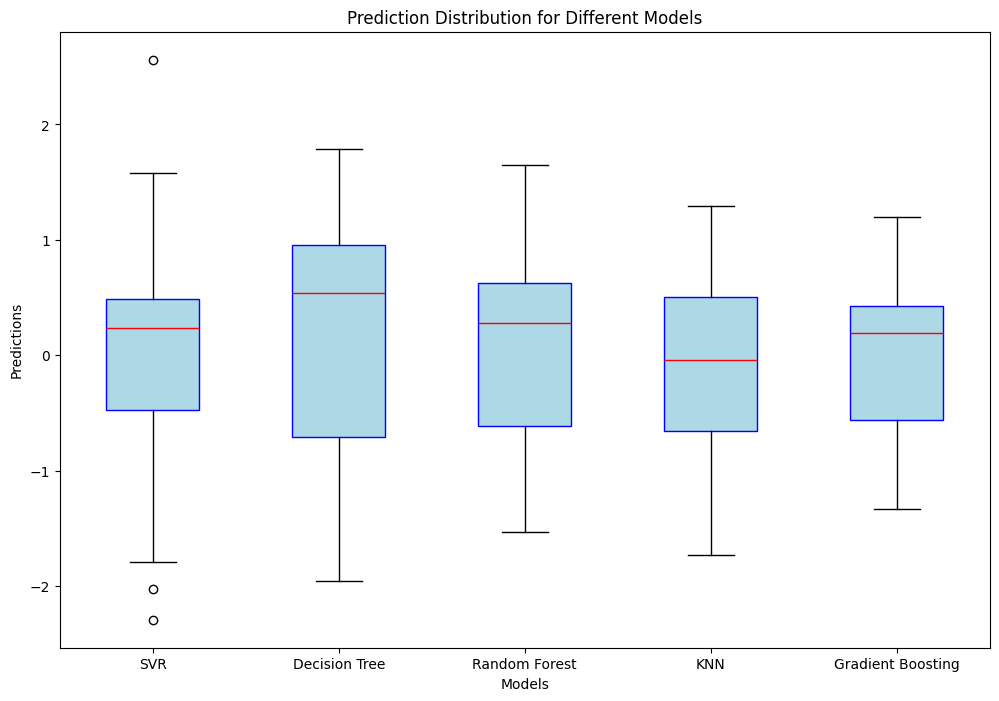

In [79]:
plt.figure(figsize=(12, 8))

# Collecting predictions from all models into one DataFrame
predictions = {
    'SVR': y_pred_svr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'KNN': y_pred_knn,
    'Gradient Boosting': y_pred_gb
}

# Creating a boxplot
plt.boxplot(predictions.values(), labels=predictions.keys(), patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))

plt.title('Prediction Distribution for Different Models')
plt.ylabel('Predictions')
plt.xlabel('Models')
plt.show()